# ECO variance comparison
To see how our variance measure compares with traiditon win% risk measures

In [1]:
import sys
import networkx as nx
import matplotlib as plt
import numpy as np
import re
import chess
import subprocess
import timeit
import pickle
import stockfish
from stockfish import Stockfish
import chess
import chess.engine
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

engine = chess.engine.SimpleEngine.popen_uci("../stockfish-10-64")
stockfish = Stockfish("../stockfish-10-64")

## Load functions

In [2]:
def varWeighted(scores, counts):
    if (len(counts)<2):
        return None
    else:
        weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)
        scoreDiffs = [(score - weightedMean)**2 for score in scores]
        V1 = sum(counts)
        V2 = sum([count**2 for count in counts])
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
        return var
    
def get_score(san):
    board = chess.Board()
    for move in san:
        board.push_san(move)
    currFen = board.fen()
    score = engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE)
    if('#' in str(score['score'])):
        if('-' in str(score['score'])):
            return -39765
        else:
            return 39765
    else:
        score = int(str(score["score"]))
    return score

def san_to_fen(san):
    board = chess.Board()
    for move in san:
        try:
            board.push_san(move)
            currFen = board.fen()
        except:
            currFen = None
    return currFen

def get_node_sd(node):
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(node)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][node])
        return node, np.sqrt(varWeighted(scores,counts))
    except:
        return node, None

## Load games graph

In [3]:
g = nx.read_gpickle('../graph-pickle/690k_30.gpickle')
len(g.nodes())

64747

In [4]:
# Get all ECO openings from .tsv files, not using this since the win % file has more info

# import pandas as pd
# import glob

# path = r'../eco_files/' # use your path
# all_files = glob.glob(path + "/*.tsv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0, sep = '\t')
#     li.append(df)

# eco_df = pd.concat(li, axis=0, ignore_index=True)
# print(eco_df.shape)
# eco_df.head(2)

## Read in df

In [5]:
eco_df = pd.read_csv('../eco_files/ECO_win_percent_chesstempo.csv')
eco_df.san = eco_df.san.astype(str)
eco_df.san = eco_df.san.apply(lambda x: " ".join(x.split()))
eco_df.san = eco_df.san.str.split(' ').tolist()
eco_df['fen'] = eco_df.san.apply(lambda x: san_to_fen(x))
eco_df['move_count'] = eco_df['san'].apply(lambda x: len(x))
print("Total NA fen:", eco_df['fen'].isna().sum())
eco_df.head(2)

Total NA fen: 0


,Opening,Num Games,ECO,Perf Rating,Avg Player,Player Win %,Draw %,Opponent Win %,san,fen,move_count
0,"Sicilian Defense, Closed Variation",26244,B23,2112,2087,0.37,0.24,0.39,"[e4, c5, Nc3]",rnbqkbnr/pp1ppppp/8/2p5/4P3/2N5/PPPP1PPP/R1BQK...,3
1,"King's Indian Attack, General",23034,A07,2316,2299,0.40,0.34,0.26,"[Nf3, d5, g3]",rnbqkbnr/ppp1pppp/8/3p4/8/5NP1/PPPPPP1P/RNBQKB...,3


In [6]:
eco_list = list(eco_df['fen'])
sd_list = []
node_fen = list(g.nodes())
for eco in eco_list:
    currFen = [fen for fen in node_fen if eco in fen]
    if(len(currFen)>0):
        currFen = str(currFen[0])
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(currFen)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][currFen])
        sd_list.append(np.sqrt(varWeighted(scores,counts)))
#         print('{} {} ||| SD :'.format(key, game), np.sqrt(varWeighted(scores,counts)), ", total Games:", sum(counts))
    except:
        sd_list.append(None)

#### Check how many NA in df, i.e. how many fens from ECO do not show up in graph

In [7]:
eco_df['sd'] = sd_list
print("Total ECO:", len(eco_df['fen']))
print("Total NA:", eco_df['sd'].isna().sum())

Total ECO: 384
Total NA: 171


In [8]:
is_NaN = eco_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = eco_df[row_has_NaN]

print(rows_with_NaN.shape)
rows_with_NaN.head()

(171, 12)


,Opening,Num Games,ECO,Perf Rating,Avg Player,Player Win %,Draw %,Opponent Win %,san,fen,move_count,sd
16,"Semi-Slav Defense, Stoltz Variation",13107,D45,2406,2376,0.39,0.39,0.22,"[d4, d5, c4, e6, Nc3, Nf6, Nf3, c6, e3, Nbd7, ...",r1bqkb1r/pp1n1ppp/2p1pn2/3p4/2PP4/2N1PN2/PPQ2P...,11,NaN
18,"Catalan Opening, Closed Variation",12921,E06,2390,2354,0.42,0.40,0.18,"[d4, Nf6, c4, e6, g3, d5, Bg2, Be7, Nf3]",rnbqk2r/ppp1bppp/4pn2/3p4/2PP4/5NP1/PP2PPBP/RN...,9,NaN
19,"Sicilian Defense, Lasker-Pelikan Variation, Sv...",12713,B33,2268,2236,0.36,0.35,0.29,"[e4, c5, Nf3, Nc6, d4, cxd4, Nxd4, Nf6, Nc3, e...",r1bqkb1r/5ppp/p1np1n2/1p1Np1B1/4P3/N7/PPP2PPP/...,17,NaN
39,"French Defense, Tarrasch Variation, Closed Var...",9325,C06,2272,2242,0.41,0.31,0.28,"[e4, e6, d4, d5, Nd2, Nf6, e5, Nfd7, Bd3, c5, ...",r1bqkb1r/pp1n1ppp/2n1p3/3pP3/3P4/3B4/PP1NNPPP/...,15,NaN
40,"Bogo-Indian Defense, Grünfeld Variation",9197,E11,2422,2382,0.43,0.35,0.22,"[d4, Nf6, c4, e6, Nf3, Bb4+, Nbd2]",rnbqk2r/pppp1ppp/4pn2/8/1bPP4/5N2/PP1NPPPP/R1B...,7,NaN


#### Sort by sd to get highest variance openings

In [9]:
eco_df.sort_values(by = ['sd'], ascending = False)[:2]

,Opening,Num Games,ECO,Perf Rating,Avg Player,Player Win %,Draw %,Opponent Win %,san,fen,move_count,sd
105,"Queen Pawn Game, Levitsky Attack",4752,D00,2210,2194,0.43,0.29,0.27,"[d4, d5, Bg5]",rnbqkbnr/ppp1pppp/8/3p2B1/3P4/8/PPP1PPPP/RN1QK...,3,261.573854
230,"Russian Game, Cozio (Lasker) Attack",2365,C42,2272,2252,0.19,0.65,0.16,"[e4, e5, Nf3, Nf6, Nxe5, d6, Nf3, Nxe4, Qe2]",rnbqkb1r/ppp2ppp/3p4/8/4n3/5N2/PPPPQPPP/RNB1KB...,9,241.762362


In [10]:
eco_df[eco_df['san'].apply(lambda x : x == ['e4', 'c5', 'c3'])]

,Opening,Num Games,ECO,Perf Rating,Avg Player,Player Win %,Draw %,Opponent Win %,san,fen,move_count,sd
2,"Sicilian Defense, Alapin Variation, General",21841,B22,2201,2161,0.37,0.29,0.34,"[e4, c5, c3]",rnbqkbnr/pp1ppppp/8/2p5/4P3/2P5/PP1P1PPP/RNBQK...,3,33.803212


#### Check sd compared to draw% for popular games

In [11]:
gamesDict = {"root" : ['e4', 'c5'],
"safe" : ['e4', 'c5', 'c3'],
"risky" : ['e4', 'c5', 'd4'],
"root2" : ['e4', 'e6', 'd4', 'd5'],
"popular2.0" : ['e4', 'e6', 'd4', 'd5', 'Nc3'],
"popular2.1" : ['e4', 'e6', 'd4', 'd5', 'Nd2'],
"safe2" : ['e4', 'e6', 'd4', 'd5', 'exd5'],
"risky2" : ['e4', 'e6', 'd4', 'd5', 'e5'],
"Ruy" : ['e4', 'e5','Nf3', 'Nc6','Bb5'],
"Vienna" : ['e4' ,'e5','d4','exd4','c3']}

#eco_df[eco_df['san'].apply(lambda x : x == ['e4','c5'])]['Draw %']
for key, game in gamesDict.items():
    try:
        draw = float(eco_df[eco_df['san'].apply(lambda x : x == game)]['Draw %'])
    except:
        draw = None
    currFen = san_to_fen(game)
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(currFen)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][currFen])
        print('{} {} ||| SD :'.format(key, game), np.sqrt(varWeighted(scores,counts)), "DRAW:", draw)
    except:
        break

root ['e4', 'c5'] ||| SD : 53.17421298817888 DRAW: None
safe ['e4', 'c5', 'c3'] ||| SD : 33.803211905697694 DRAW: 0.29
risky ['e4', 'c5', 'd4'] ||| SD : 112.59554494204002 DRAW: None
root2 ['e4', 'e6', 'd4', 'd5'] ||| SD : 35.29555838233849 DRAW: None
popular2.0 ['e4', 'e6', 'd4', 'd5', 'Nc3'] ||| SD : 38.82435952658399 DRAW: 0.31
popular2.1 ['e4', 'e6', 'd4', 'd5', 'Nd2'] ||| SD : 73.60617708334175 DRAW: 0.28
safe2 ['e4', 'e6', 'd4', 'd5', 'exd5'] ||| SD : 59.07250112917537 DRAW: 0.39
risky2 ['e4', 'e6', 'd4', 'd5', 'e5'] ||| SD : 78.55239442769992 DRAW: 0.22
Ruy ['e4', 'e5', 'Nf3', 'Nc6', 'Bb5'] ||| SD : 19.630732457868167 DRAW: 0.36
Vienna ['e4', 'e5', 'd4', 'exd4', 'c3'] ||| SD : 35.14133659917036 DRAW: None


## Plot relationship between sd and draw%

#### Distribution of sd across ECO openings

(0, 500)

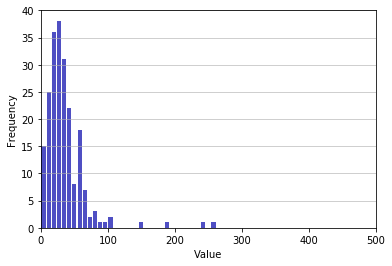

In [12]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=eco_df['sd'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.8)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = 0, xmax = 500)

#### Correlation between sd and draw%

CORR: 0.1327331139555662


(0.14577134555207863, 0.45)

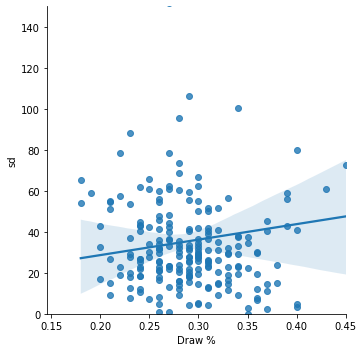

In [13]:
import seaborn as sns
print("CORR:",eco_df['Draw %'].corr(eco_df['sd']))
sns.lmplot('Draw %', 'sd', data = eco_df)
plt.ylim(0,150)
plt.xlim(None,0.45)

#### Correlation between sd and move count of opening

CORR: -0.15553521116126137


(0, 10)

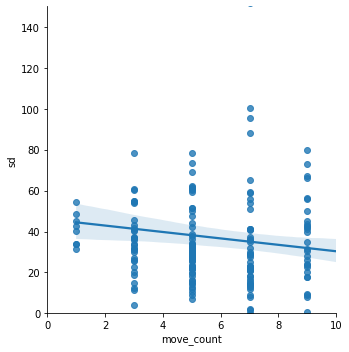

In [14]:
print("CORR:",eco_df['move_count'].corr(eco_df['sd']))
sns.lmplot('move_count', 'sd', data = eco_df)
plt.ylim(0,150)
plt.xlim(0,10)